In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import sys; sys.path.insert(0, '../')
from exp import nb_d2l_utils
import math
%matplotlib inline

In [2]:
torch.manual_seed(0)
# torch.cuda.manual_seed_all(0)

torch.__version__               # PyTorch version
# torch.version.cuda              # Corresponding CUDA version
# torch.backends.cudnn.version()  # Corresponding cuDNN version
# torch.cuda.get_device_name(0)   # GPU type

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True

In [3]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((28,28)),
    transforms.ToTensor(),
])

train_data = torchvision.datasets.FashionMNIST('path/to/imagenet_root/', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)

vali_data = torchvision.datasets.FashionMNIST('path/to/imagenet_root/', train=False, transform=transform, download=True)
vali_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

            
X, y = iter(train_loader).next()
X.shape, y.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [4]:
# train.pt and test.pt can be loaded by troch.load(), just normal python object
d = torch.load('path/to/imagenet_root/FashionMNIST/processed/training.pt')
d[0].shape, d[1].shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

torch.Size([16, 1, 28, 28]) torch.Size([16])


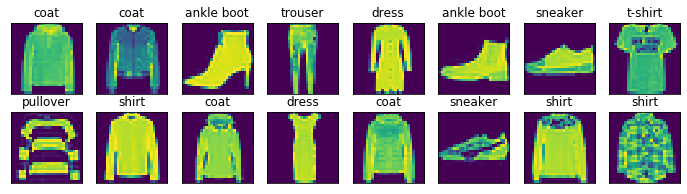

In [7]:
for X, y in train_loader:
    print(X.shape, y.shape)
    nb_d2l_utils.show_images(X.squeeze(dim=1), 2, 8, get_fashion_mnist_labels(y))
    break

In [38]:
X.mean(), X.std()

(tensor(0.3432), tensor(0.3914))

In [82]:
#export
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None, device=None):
    if device:
        xb.to(device)
        yb.to(device)
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def acc_batch(model, xb, yb, device=None):
    if device:
        xb.to(device)
        yb.to(device)
    return (torch.argmax(model(xb), dim=1)==yb).float().mean().item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, device=None):
    if device:
        model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt, device)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb, device) for xb, yb in valid_dl]
            )
            acc, nums = zip(
                *[acc_batch(model, xb, yb, device) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)

        print(epoch, val_loss, val_acc)

In [83]:
class Mnist_Linear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(784, 64)
        self.linear2 = torch.nn.Linear(64, 10)
    
    def forward(self, xb):
        xb = xb.view(-1,28*28)
        xb = self.linear1(xb).relu_()
        xb = self.linear2(xb).relu_()
        return xb
    
model = Mnist_Linear()

In [84]:
opt = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [85]:
fit(1, model, loss, opt, train_loader, vali_loader)

0 1.2582335639715194 8.079466666666667
